# Embeddings

## What are Embeddings?

For similarity comparisons in Deep Learning: Usage of "Embeddings"

What are they?

"An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models."

For a better understanding let's visualize some embeddings.

### Embeddings Visualization

Popular approach for embedding visualization: T-SNE (t-Distributed Stochastic Neighbor Embedding)

As per SciKitLearn:

- Converts similarities between data points to joint probabilities
- Tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data
- Has a cost function that is not convex, i.e. with different initializations we can get different results
- Highly recommended to use another dimensionality reduction method to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high

Let's use T-SNE to have a look at our original classification embeddings.
To to that, let's recreate the original model and train it on our dataset:

In [1]:
from core.dataset import DGSAlphabet

# Import the dataset
dataset = DGSAlphabet()
categorical_dataset = dataset.load_categorical_one_hot()

x_train = categorical_dataset.x_train
y_train = categorical_dataset.y_train
x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

In [2]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, AlphaDropout, LayerNormalization
from core.model import new_SNN_encoder, new_SNN_classifier

# Encoder part
snn_encoder = new_SNN_encoder()

# Full classifier
snn_classifier = new_SNN_classifier(
    snn_encoder,
    num_classes=y_test[0].shape[0]
)

snn_classifier.summary()

Model: "SNN_6_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Landmark_Input (InputLayer  [(None, 21, 3)]           0         
 )                                                               
                                                                 
 Layer_Norm (LayerNormaliza  (None, 21, 3)             6         
 tion)                                                           
                                                                 
 Flatten_Landmarks (Flatten  (None, 63)                0         
 )                                                               
                                                                 
 Dense_1 (Dense)             (None, 1728)              110592    
                                                                 
 Dropout_1 (AlphaDropout)    (None, 1728)              0         
                                                  

In [3]:
from core.util import new_default_callbacks

# Reduce learning rate if no improvement is made (after 5 epochs)
# Use callback to stop training if no improvement is made (after 10 epochs)
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_acc",
    mode="max"
)

In [4]:
from keras.optimizers import Adam

# Use Adam optimizer
adam = Adam(learning_rate=0.001, beta_2=0.99, epsilon=0.01)

# Compile model
snn_classifier.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['acc']
)

In [5]:
# Training hyperparameters
epochs = 100
val_split = .2
batch_size=32

In [6]:
# Start training
history = snn_classifier.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
147/147 [==============================] - 5s 24ms/step - loss: 3.0328 - acc: 0.1159 - val_loss: 2.3676 - val_acc: 0.2258 - lr: 0.0010
Epoch 2/100
147/147 [==============================] - 4s 27ms/step - loss: 1.9742 - acc: 0.3170 - val_loss: 1.4406 - val_acc: 0.4671 - lr: 0.0010
Epoch 3/100
147/147 [==============================] - 4s 28ms/step - loss: 1.4000 - acc: 0.4839 - val_loss: 1.2588 - val_acc: 0.5663 - lr: 0.0010
Epoch 4/100
147/147 [==============================] - 4s 25ms/step - loss: 1.0896 - acc: 0.5914 - val_loss: 0.9288 - val_acc: 0.6938 - lr: 0.0010
Epoch 5/100
147/147 [==============================] - 4s 24ms/step - loss: 0.9245 - acc: 0.6509 - val_loss: 0.6380 - val_acc: 0.7399 - lr: 0.0010
Epoch 6/100
147/147 [==============================] - 4s 24ms/step - loss: 0.8262 - acc: 0.6922 - val_loss: 0.6322 - val_acc: 0.7725 - lr: 0.0010
Epoch 7/100
147/147 [==============================] - 4s 25ms/step - loss: 0.7249 - acc: 0.7279 - val_loss: 0.5921 - 

In [7]:
from pathlib import Path

MODEL_DIR = "models"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

snn_classifier.save(f"{MODEL_DIR}/original_snn6.keras")

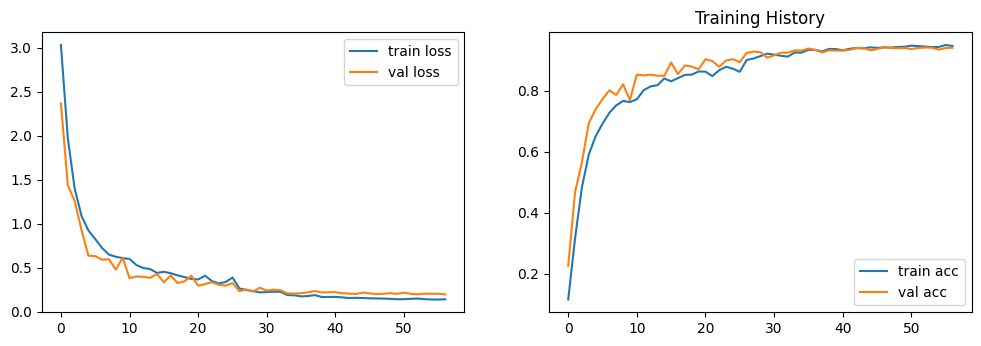

In [8]:
from core.viz import visualize_history

visualize_history(history, ["loss", "acc"])

In [9]:
# And evaluate the model on test data
loss, acc = snn_classifier.evaluate(x_test, y_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.2818 acc=0.9309


That looks similar to our original results.

Now let's visualize the embeddings. For this we'll focus on the model's encoder part (up to "Dense_6"):

In [10]:
# And get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

46/46 [==============================] - 0s 6ms/step


Luckily, the weight dimensions are less than 50, so we can use them with T-SNE straight away:

In [11]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1462 samples in 0.000s...
[t-SNE] Computed neighbors for 1462 samples in 0.339s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1462
[t-SNE] Computed conditional probabilities for sample 1462 / 1462
[t-SNE] Mean sigma: 17.704272
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.741528
[t-SNE] KL divergence after 1000 iterations: 0.377566


If we take a look at our embeddings (which are now reduced to 3 dimensions), we can see how embeddings for different categories are separated in space:

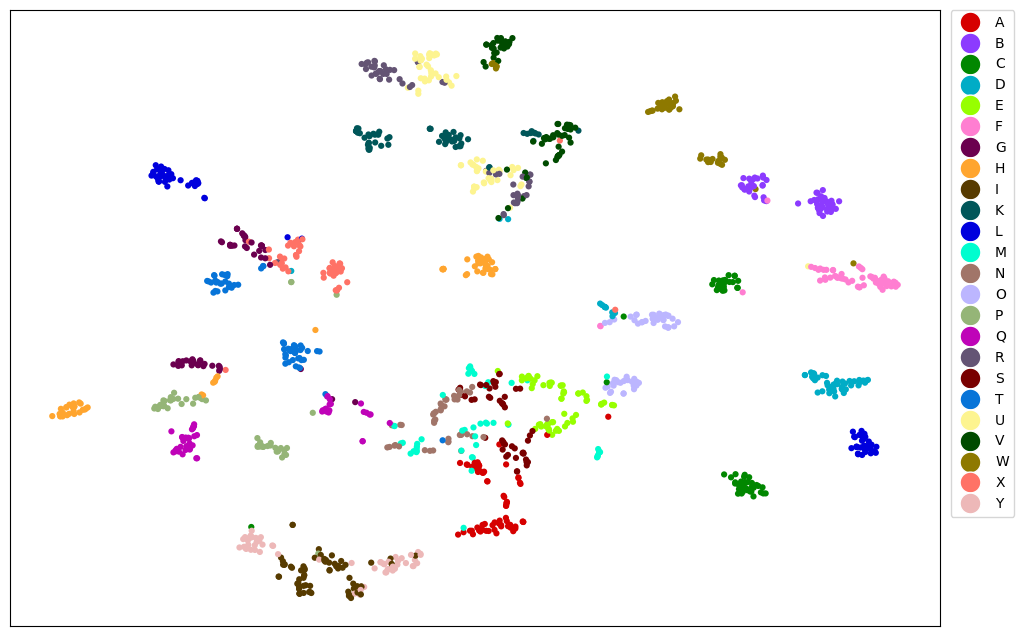

In [12]:
import numpy as np
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
y_test_int_labels = np.argmax(y_test, axis=1)
visualize_embeddings(
    reduced_embeddings,
    y_test_int_labels,
    label_map
)

Let's compare the embeddings' visualization to our model's confusion matrix:

46/46 [==============================] - 0s 5ms/step


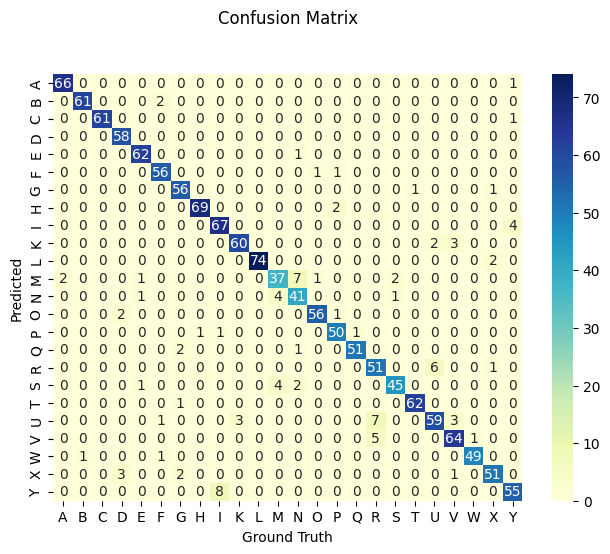

In [13]:
from core.viz import visualize_confusion_matrix


predictions = snn_classifier.predict(x_test)

prediction_classes = np.argmax(predictions, axis=-1)
gt_classes = np.argmax(y_test, axis=-1)
pretty_classes = [lbl.upper() for lbl in label_map.keys()]

visualize_confusion_matrix(gt_classes, prediction_classes, pretty_classes)

We can see that the model most often confuses:

- R with U
- N with M
- Y with I
- U with R
- S with R

This actually corresponds to overlaps in the embeddigs' visualization.